In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical, Normal, MultivariateNormal
from collections import namedtuple
from typing import NamedTuple
from itertools import chain

import gym
from tqdm import tqdm_notebook
import numpy as np
from collections import deque
from copy import deepcopy

In [2]:
from policy_generator.policy_instances.envs.simple_arena import ActionSpace

In [3]:
#device to run model on 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = 'cpu'

In [4]:
class ObsSpace(NamedTuple):
    agent: np.ndarray
    agent_direction: int
    target: np.ndarray
    velocity: int
        
def unpack_state(state):
    state = ObsSpace(**state[0] if isinstance(state, tuple) else state)
    unpack_state = list(chain(state.agent, state.target, [state.velocity, state.agent_direction]))
    state = torch.Tensor(unpack_state).float().unsqueeze(0).to(DEVICE)
    return state

In [5]:
#class for actor-critic network
class ActorCriticNetwork(nn.Module):
    
    def __init__(self, obs_space, action_space):
        '''
        Args:
        - obs_space (int): observation space
        - action_space (int): action space
        
        '''
        super(ActorCriticNetwork, self).__init__()
        self.action_space = action_space
        # self.action_std = action_std

        self.actor = nn.Sequential(
                            nn.Linear(obs_space, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_space),
                            nn.Tanh())

        self.critic = nn.Sequential(
                        nn.Linear(obs_space, 64),
                        nn.Tanh(),
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, 1))
        
    def forward(self):
        ''' Not implemented since we call the individual actor and critc networks for forward pass
        '''
        raise NotImplementedError
        
    def select_action(self, state):
        ''' Selects an action given current state
        Args:
        - network (Torch NN): network to process state
        - state (Array): Array of action space in an environment

        Return:
        - (int): action that is selected
        - (float): log probability of selecting that action given state and network
        '''
    
        #convert state to float tensor, add 1 dimension, allocate tensor on device
        state = unpack_state(state)

        #use network to predict action probabilities
        actions = self.actor(state)

        #sample an action using the Gaussian distribution
        m = Normal(actions, 0.1)
        actions = m.sample()
        # print(np.argmax(actions.detach().numpy()))

        #return action
        return np.argmax(actions.detach().numpy()), m.log_prob(actions)
    
    def evaluate_action(self, states, actions):
        ''' Get log probability and entropy of an action taken in given state
        Args:
        - states (Array): array of states to be evaluated
        - actions (Array): array of actions to be evaluated
        
        '''
        
        #convert state to float tensor, add 1 dimension, allocate tensor on device
        states_tensor = torch.stack([unpack_state(state) for state in states]).squeeze(1)

        #use network to predict action probabilities
        actions = self.actor(states_tensor)

        #get probability distribution
        m = Normal(actions, 0.1)

        #return log_prob and entropy
        return m.log_prob(torch.Tensor(actions)), m.entropy()

In [6]:
#Proximal Policy Optimization
class PPO_policy():
    
    def __init__(self, γ, ϵ, β, δ, c1, c2, k_epoch, obs_space, action_space, α_θ, αv):
        '''
        Args:
        - γ (float): discount factor
        - ϵ (float): soft surrogate objective constraint
        - β (float): KL (Kullback–Leibler) penalty 
        - δ (float): KL divergence adaptive target
        - c1 (float): value loss weight
        - c2 (float): entropy weight
        - k_epoch (int): number of epochs to optimize
        - obs_space (int): observation space
        - action_space (int): action space
        - α_θ (float): actor learning rate
        - αv (float): critic learning rate
        
        '''
        self.γ = γ
        self.ϵ = ϵ
        self.β = β
        self.δ = δ
        self.c1 = c1
        self.c2 = c2
        self.k_epoch = k_epoch
        self.actor_critic = ActorCriticNetwork(obs_space, action_space)
        self.optimizer = torch.optim.Adam([
            {'params': self.actor_critic.actor.parameters(), 'lr': α_θ},
            {'params': self.actor_critic.critic.parameters(), 'lr': αv}
        ])
        
        #buffer to store current batch
        self.batch = []
    
    def process_rewards(self, rewards, terminals):
        ''' Converts our rewards history into cumulative discounted rewards
        Args:
        - rewards (Array): array of rewards 

        Returns:
        - G (Array): array of cumulative discounted rewards
        '''
        #Calculate Gt (cumulative discounted rewards)
        G = []

        #track cumulative reward
        total_r = 0

        #iterate rewards from Gt to G0
        for r, done in zip(reversed(rewards), reversed(terminals)):

            #Base case: G(T) = r(T)
            #Recursive: G(t) = r(t) + G(t+1)^DISCOUNT
            total_r = r + total_r * self.γ

            #no future rewards if current step is terminal
            if done:
                total_r = r

            #add to front of G
            G.insert(0, total_r)

        #whitening rewards
        G = torch.tensor(G)
        G = (G - G.mean())/G.std()

        return G
    
    def kl_divergence(self, old_lps, new_lps):
        ''' Calculate distance between two distributions with KL divergence
        Args:
        - old_lps (Array): array of old policy log probabilities
        - new_lps (Array): array of new policy log probabilities
        '''
        
        #track kl divergence
        total = 0
        
        #sum up divergence for all actions
        for old_lp, new_lp in zip(old_lps, new_lps):
            
            #same as old_lp * log(old_prob/new_prob) cuz of log rules
            total += old_lp * (old_lp - new_lp)

        return total
    
    
    def penalty_update(self):
        ''' Update policy using surrogate objective with adaptive KL penalty
        '''
        
        #get items from current batch
        states = [sample[0] for sample in self.batch]
        actions = [sample[1] for sample in self.batch]
        rewards = [sample[2] for sample in self.batch]
        old_lps = [sample[3] for sample in self.batch]
        terminals = [sample[4] for sample in self.batch]

        #calculate cumulative discounted rewards
        Gt = self.process_rewards(rewards, terminals)

        #track divergence
        divergence = 0

        #perform k-epoch update
        for epoch in range(self.k_epoch):

            #get ratio
            new_lps, entropies = self.actor_critic.evaluate_action(states, actions)
            #same as new_prob / old_prob
            ratios = torch.exp(new_lps - torch.Tensor(old_lps))

            #compute advantages
            states_tensor = torch.stack([unpack_state(state) for state in states]).squeeze(1)
            vals = self.actor_critic.critic(states_tensor).squeeze(1).detach()
            advantages = Gt - vals

            #get loss with adaptive kl penalty
            divergence = self.kl_divergence(old_lps, new_lps).detach()
            loss = -ratios * advantages + self.β * divergence

            #SGD via Adam
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        #update adaptive penalty
        if divergence >= 1.5 * self.δ:
            self.β *= 2
        elif divergence <= self.δ / 1.5:
            self.β /= 2
        
        #clear batch buffer
        self.batch = []
            
    def clipped_update(self):
        ''' Update policy using clipped surrogate objective
        '''
        #get items from trajectory
        states = [sample[0] for sample in self.batch]
        actions = [sample[1] for sample in self.batch]
        rewards = [sample[2] for sample in self.batch]
        old_lps = [sample[3] for sample in self.batch]
        terminals = [sample[4] for sample in self.batch]

        #calculate cumulative discounted rewards
        Gt = self.process_rewards(rewards, terminals)

        #perform k-epoch update
        for epoch in range(self.k_epoch):

            #get ratio
            new_lps, entropies = self.actor_critic.evaluate_action(states, actions)

            ratios = torch.exp(new_lps - torch.stack(old_lps).squeeze(1).detach())

            #compute advantages
            states_tensor = torch.stack([unpack_state(state) for state in states]).squeeze(1)
            vals = self.actor_critic.critic(states_tensor).squeeze(1).detach()
            advantages = Gt - vals

            #clip surrogate objective
            surrogate1 = torch.clamp(ratios, min=1 - self.ϵ, max=1 + self.ϵ) * advantages.unsqueeze(0).T
            surrogate2 = ratios * advantages.unsqueeze(0).T

            #loss, flip signs since this is gradient descent
            loss =  -torch.min(surrogate1, surrogate2) + self.c1 * F.mse_loss(Gt, vals) - self.c2 * entropies

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
        
        #clear batch buffer
        self.batch = []

In [7]:
#Make environment
env = gym.make('policy_instances/SimpleArena-v0')

#seeds
np.random.seed(2)
# env.seed(2)
torch.manual_seed(2)

#environment parameters
obs_space = env.shape
action_space = env.action_space.n

In [8]:
ppo_policy = PPO_policy(γ=0.99, ϵ=0.2, β=1, δ=0.01, c1=0.5, c2=0.01, k_epoch=40, 
                        obs_space=obs_space, action_space=action_space, α_θ = 1e-5, αv = 1e-5)

In [9]:
state = env.reset()

In [10]:
actions_mean = ppo_policy.actor_critic.actor(unpack_state(state))

In [11]:
actions_mean

tensor([[-0.2007,  0.0983, -0.0886, -0.0645,  0.0816]],
       grad_fn=<TanhBackward0>)

In [12]:
#Experiment/Policy Hyperparameters

#number of steps to train
TRAIN_STEPS = 100000

#max steps per episode
MAX_STEPS = 500

#batch training size
BATCH_SIZE = 1600

#solved environment score
SOLVED_SCORE = 195

In [13]:
#track scores
scores = []

#recent 100 scores
recent_scores = deque(maxlen=100)

#reset environment, initiable variables
state = env.reset()
curr_step = 0
score = 0

#run training loop
for step in tqdm_notebook(range(1, TRAIN_STEPS)):
    
    #env.render()
    curr_step += 1

    #select action
    action, lp = ppo_policy.actor_critic.select_action(state)

    #execute action
    new_state, reward, done, _, _ = env.step(action)
    
    #track rewards
    score += reward

    #store into trajectory
    ppo_policy.batch.append([state, action, reward, lp, done])

    #optimize surrogate
    if step % BATCH_SIZE == 0:
        ppo_policy.clipped_update()

    #end episode
    if done or curr_step >= MAX_STEPS:
        state = env.reset()
        curr_step = 0
        scores.append(score)
        recent_scores.append(score)
        score = 0
        continue
        
    #check if solved environment, early stopping
    if len(recent_scores) >= 100 and np.array(recent_scores).mean() >= SOLVED_SCORE:
        break

    #move into new state
    state = new_state    

/tmp/ipykernel_1624/1694157310.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm_notebook(range(1, TRAIN_STEPS)):


  0%|          | 0/99999 [00:00<?, ?it/s]

/home/beast/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


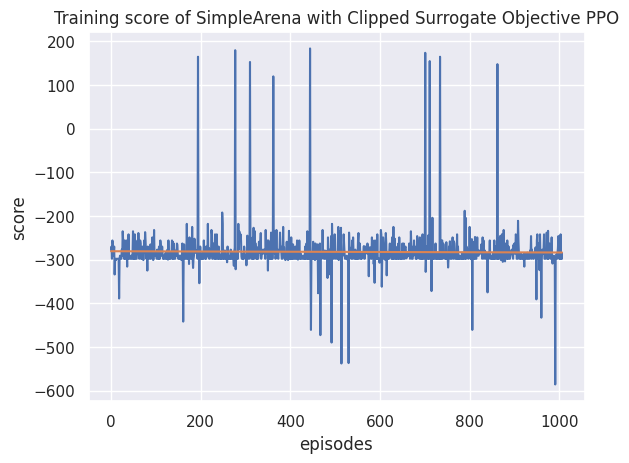

In [14]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Training score of SimpleArena with Clipped Surrogate Objective PPO')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

In [18]:
#evaluate policy

done = False
state = env.reset()
scores = []

for _ in tqdm_notebook(range(50)):
    state = env.reset()
    done = False
    score = 0
    while not done:
        #env.render()
        action, lp = ppo_policy.actor_critic.select_action(state)
        new_state, reward, done, info, _ = env.step(env.action_space.sample())
        score += reward
        state = new_state
    scores.append(score)
env.close()

/tmp/ipykernel_1624/1252809515.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(50)):


  0%|          | 0/50 [00:00<?, ?it/s]

In [19]:
np.array(scores).mean()

-7.86

In [20]:
env.close()

In [3]:
#Make environment
env = gym.make('LunarLanderContinuous-v2')


In [4]:
env.reset()

(array([-0.00618267,  1.4192958 , -0.62625325,  0.37224102,  0.00717097,
         0.14185576,  0.        ,  0.        ], dtype=float32),
 {})

In [5]:
env.step(1)

IndexError: invalid index to scalar variable.